In [1]:
%load_ext autoreload
%matplotlib inline

# Isolation Forest and new evaluation approach

Deleted old segmentation and evaluation code. Added new one based on splitting the input into different ipoc segments instead of splitting the output into anomaly segments.

The new segmentation and evaluation approach is described in notes.md on 23/04. 

In [2]:
import os, sys
import numpy as np
import pandas as pd
import sklearn.metrics
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.anomalies
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection.factory import *
from evaluation import evaluation, segmentation
from feature_extraction import feature_extraction, preprocessing

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
df = feature_extraction.load_features_from_file("features_b1_sw-30min*")
df_scaled = preprocessing.scale_robust(df)

Loading file '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min_2018-02-26.csv' instead.


In [4]:
labels = db.query_elogbook_anomalies()
labels_all = db.query_elogbook_no_info()
print(len(labels), len(labels_all))

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
16 53


## Fit and score data

In [5]:
clf = IsolationForest(n_estimators=500, max_samples=256, n_jobs=2, verbose=1)
df_scored = clf.fit_and_append_scores(df_scaled)

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.9s finished


Split data in segments built with out of different amounts of anomalous points used

In [6]:
df_scored.head()

MKI.UA23.IPOC.CB1:T_LENGTH  MKI.UA23.IPOC.AB1:T_LENGTH  \
2016-04-17 00:50:36                    0.000042                   -0.001497   
2016-04-17 00:50:46                    0.000251                   -0.000208   
2016-04-17 00:50:56                   -0.000125                   -0.000374   
2016-04-17 00:51:06                    0.000502                    0.000000   
2016-04-17 00:51:16                    0.000209                   -0.000458   

                     MKI.UA23.IPOC.AB1:E_KICK  MKI.UA23.IPOC.DB1:E_KICK  \
2016-04-17 00:50:36                  0.394351                  0.394445   
2016-04-17 00:50:46                  0.394351                  0.394445   
2016-04-17 00:50:56                  0.394351                  0.394445   
2016-04-17 00:51:06                  0.394351                  0.394445   
2016-04-17 00:51:16                  0.394351                  0.394445   

                     MKI.UA23.IPOC.AB1:T_FALLTIME  \
2016-04-17 00:50:36                      3.885714   
2016-04-17 00:50:46                      0.609524   
2016-04-17 00:50:56                      0.676190   
2016-04-17 00:51:06                      0.600000   
2016-04-17 00:51:16                      0.590476   

                     MKI.UA23.IPOC.DB1:T_FALLTIME  \
2016-04-17 00:50:36                      3.221154   
2016-04-17 00:50:46                      0.548077   
2016-04-17 00:50:56                      0.346154   
2016-04-17 00:51:06                      0.096154   
2016-04-17 00:51:16                      0.375000   

                     MKI.UA23.IPOC.AB1:T_START_TH  MKI.UA23.IPOC.CB1:E_KICK  \
2016-04-17 00:50:36                           1.8                  0.394445   
2016-04-17 00:50:46                          -0.2                  0.394445   
2016-04-17 00:50:56                          -0.2                  0.394445   
2016-04-17 00:51:06                           0.0                  0.394445   
2016-04-17 00:51:16                          -0.2                  0.394445   

                     MKI.UA23.IPOC.CB1:I_STRENGTH  \
2016-04-17 00:50:36                     -7.467957   
2016-04-17 00:50:46                     -3.396237   
2016-04-17 00:50:56                     -3.128716   
2016-04-17 00:51:06                     -2.868012   
2016-04-17 00:51:16                     -2.604854   

                     MKI.UA23.IPOC.BB1:T_RISETIME    ...     \
2016-04-17 00:50:36                      0.215686    ...      
2016-04-17 00:50:46                     -0.019608    ...      
2016-04-17 00:50:56                     -0.019608    ...      
2016-04-17 00:51:06                      0.000000    ...      
2016-04-17 00:51:16                     -0.058824    ...      

                     MKI.A5L2.B1:TEMP_TUBE_UP:SW_SUM_1800_s  \
2016-04-17 00:50:36                               -0.439748   
2016-04-17 00:50:46                               -0.439748   
2016-04-17 00:50:56                               -0.439748   
2016-04-17 00:51:06                               -0.439748   
2016-04-17 00:51:16                               -0.439748   

                     MKI.D5L2.B1:TEMP_TUBE_DOWN:SW_SUM_1800_s  \
2016-04-17 00:50:36                                  -0.53356   
2016-04-17 00:50:46                                  -0.53356   
2016-04-17 00:50:56                                  -0.53356   
2016-04-17 00:51:06                                  -0.53356   
2016-04-17 00:51:16                                  -0.53356   

                     MKI.C5L2.B1:TEMP_MAGNET_UP:SW_SUM_1800_s  \
2016-04-17 00:50:36                                 -0.756493   
2016-04-17 00:50:46                                 -0.756493   
2016-04-17 00:50:56                                 -0.756493   
2016-04-17 00:51:06                                 -0.756493   
2016-04-17 00:51:16                                 -0.756493   

                     MKI.C5L2.B1:TEMP_MAGNET_DOWN:SW_SUM_1800_s  \
2016-04-17 00:50:36                                   -0

## Split scored data into segments

In [7]:
segments = segmentation.df_to_segments(df_scored, segmentation_distance=30)

segments = [s for s in segments if len(s) > 2]

In [8]:
segmentation.print_segments(segments[0:3])

Segment from 2016-04-17 00:50:36 to 2016-04-17 01:28:21
	Length: 0 days 00:37:45. Points: 69.
	Anomalous: False. Prediction: False. Anomaly score: 0.4 

Segment from 2016-04-17 02:44:55 to 2016-04-17 02:55:55
	Length: 0 days 00:11:00. Points: 67.
	Anomalous: False. Prediction: False. Anomaly score: 0.4 

Segment from 2016-04-17 05:22:19 to 2016-04-17 05:59:01
	Length: 0 days 00:36:42. Points: 81.
	Anomalous: False. Prediction: False. Anomaly score: 0.33 



## Add ground truth

In [9]:
segments = segmentation.set_ground_truth(segments, labels_all)

In [10]:
segmentation.print_segment_stats(segments)

Number of segments:     591
Anomalous segments:     96
Predicted an. segments: 0
Min segment length:     0 days 00:02:14, points: 3
Mean segment length:    0 days 00:45:43, points: 77
Max segment length:     0 days 08:38:00, points: 3109


## Evaluation with set top k value

Make predictions with top k = 1000

In [11]:
segments = segmentation.set_predictions(segments, k=1000)

setting predictions on segments with k =  1000, threshold = 0.565


In [12]:
segmentation.print_segment_stats(segments)

Number of segments:     591
Anomalous segments:     96
Predicted an. segments: 210
Min segment length:     0 days 00:02:14, points: 3
Mean segment length:    0 days 00:45:43, points: 77
Max segment length:     0 days 08:38:00, points: 3109


In [13]:
segments_labels = [s.get_label() for s in segments if s.is_labeled()]
segments_labels_ids = set([s.id for s in segments_labels])

print("Labels:", len(labels_all))
print("Segments with label assigned to them:", len(segments_labels))
print("Unique labels assigned to segments:", len(segments_labels_ids))
print()

correctly_predicted_anomalous_segments = [s for s in segments if s.is_predicted_anomalous() and s.is_labeled()]
print("Predicted anomalous segments correct:", len(correctly_predicted_anomalous_segments))

Labels: 53
Segments with label assigned to them: 96
Unique labels assigned to segments: 37

Predicted anomalous segments correct: 35


In [14]:
# old version of creating y_true y_pred results using segment.is_predicted_anomalous() 
# which relies on segmentation.set_predictions(segments, k) to set the predictions
# new version in evaluation.py calculates anomaly scores for segments 
# and creates PR curves by calculating (precision, recall) points for all options for k
def segment_predictions_to_truth_and_pred(segments):
    results = pd.DataFrame(index=range(len(segments)), columns=["y_true", "y_pred", "label_id"])

    for i, segment in enumerate(segments):
        results.iloc[i]["y_true", "y_pred"] = [segment.is_labeled(), segment.is_predicted_anomalous()]

        if segment.is_labeled():
            results.iloc[i]["label_id"] = segment.get_label().id

    label_ids = results[~results["label_id"].isnull()]["label_id"].unique()
    for label_id in label_ids:
        labels_mask = results["label_id"] == label_id

        predicted_anomalous = results[labels_mask]["y_pred"].any()

        # remove entries for for this label
        results = results[~labels_mask]

        # add 1 entry to make label responsible for only 1 TP or FN
        results.loc[results.index.max()+1] = [True, predicted_anomalous, label_id]
        
    return results


def truth_and_pred_to_precision_recall(df):
    y_true = df.y_true.astype('bool')
    y_pred = df.y_pred.astype('bool')

    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true, y_pred).ravel()

    precision = tp / (tp + fp) if tp > 0 else 0
    recall = tp / (tp + fn)
    
    print("TP:  {:4} | FP:  {:4}  || sum: {:4}".format(tp, fp, tp+fp))
    print("FN:  {:4} | TN:  {:4}  || sum: {:4}".format(fn, tn, fn+tn))
    print("PRECISION: {:.2f}, RECALL: {:.2f}".format(precision, recall))
    
    return precision, recall
    
def evaluate_scored_segments_for_k(segments, k):
    segments = segmentation.set_predictions(segments, k)
    
    results = segment_predictions_to_truth_and_pred(segments)
    
    precision, recall = truth_and_pred_to_precision_recall(results)
    
    return precision, recall

def evaluate_scored_segments_for_k_range(segments, k_range):
    pr = []

    for k in k_range:
        pr.append(evaluate_scored_segments_for_k(segments, k))
        print()

    plt.figure()
    plt.ylim(-0.1, 1.1)
    plt.xticks([])
    plt.plot([p for p, r in pr], label="precision")
    plt.plot([r for p, r in pr], label="recall")
    plt.legend(loc="lower right")

In [15]:
k_range = range(250, 5000, 250)

setting predictions on segments with k =   250, threshold = 0.716
TP:    14 | FP:    99  || sum:  113
FN:    23 | TN:   396  || sum:  419
PRECISION: 0.12, RECALL: 0.38

setting predictions on segments with k =   500, threshold = 0.637
TP:    21 | FP:   148  || sum:  169
FN:    16 | TN:   347  || sum:  363
PRECISION: 0.12, RECALL: 0.57

setting predictions on segments with k =   750, threshold = 0.593
TP:    22 | FP:   165  || sum:  187
FN:    15 | TN:   330  || sum:  345
PRECISION: 0.12, RECALL: 0.59

setting predictions on segments with k =  1000, threshold = 0.565
TP:    23 | FP:   175  || sum:  198
FN:    14 | TN:   320  || sum:  334
PRECISION: 0.12, RECALL: 0.62

setting predictions on segments with k =  1250, threshold = 0.547
TP:    24 | FP:   183  || sum:  207
FN:    13 | TN:   312  || sum:  325
PRECISION: 0.12, RECALL: 0.65

setting predictions on segments with k =  1500, threshold = 0.529
TP:    25 | FP:   189  || sum:  214
FN:    12 | TN:   306  || sum:  318
PRECISION: 0.12, 

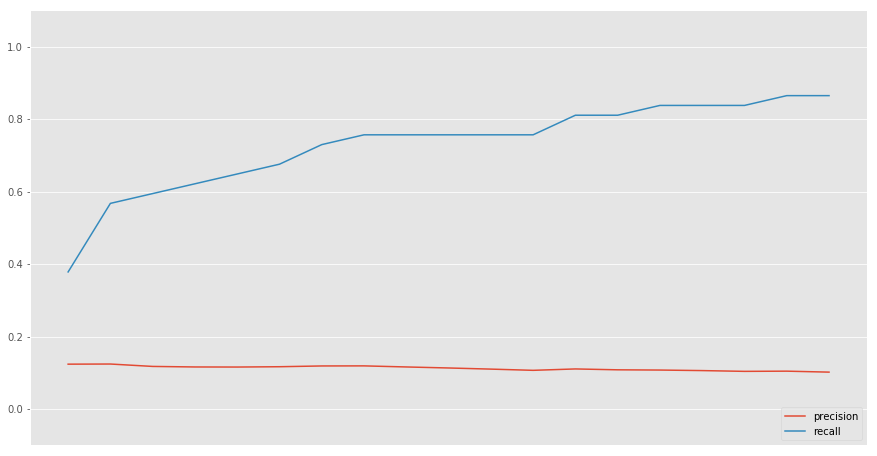

In [16]:
evaluate_scored_segments_for_k_range(segments, k_range)

### Compare to DummyDetectors

In [17]:
def dummy_detector_pipeline(detector, data, labels, k_range):
    df_scored = detector.fit_and_append_scores(data)

    segments = segmentation.df_to_segments(df_scored, segmentation_distance=30)
    segments = [s for s in segments if len(s) > 2]
    segments = segmentation.set_ground_truth(segments, labels)

    evaluate_scored_segments_for_k_range(segments, k_range)

setting predictions on segments with k =   250, threshold = 1.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, RECALL: 1.00

setting predictions on segments with k =   500, threshold = 1.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, RECALL: 1.00

setting predictions on segments with k =   750, threshold = 1.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, RECALL: 1.00

setting predictions on segments with k =  1000, threshold = 1.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, RECALL: 1.00

setting predictions on segments with k =  1250, threshold = 1.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, RECALL: 1.00

setting predictions on segments with k =  1500, threshold = 1.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, 

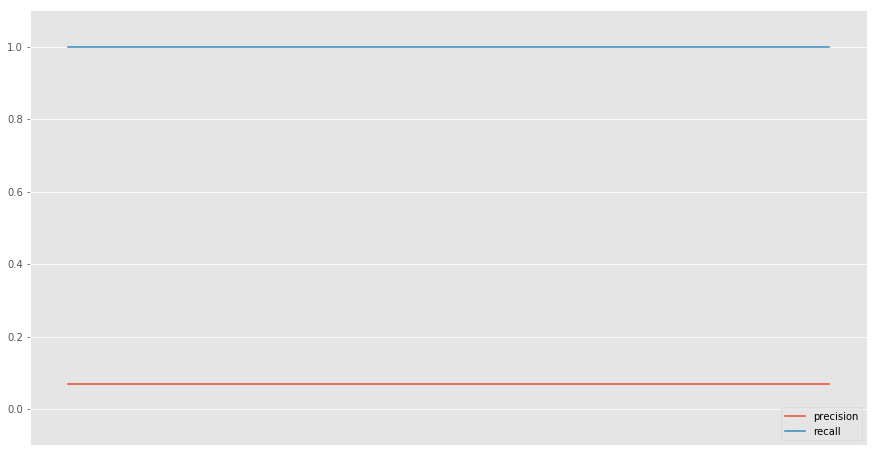

In [18]:
dummy_detector_pipeline(create_constant_detector(1.0), df_scaled, labels_all, k_range)

setting predictions on segments with k =   250, threshold = 0.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, RECALL: 1.00

setting predictions on segments with k =   500, threshold = 0.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, RECALL: 1.00

setting predictions on segments with k =   750, threshold = 0.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, RECALL: 1.00

setting predictions on segments with k =  1000, threshold = 0.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, RECALL: 1.00

setting predictions on segments with k =  1250, threshold = 0.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, RECALL: 1.00

setting predictions on segments with k =  1500, threshold = 0.000
TP:    37 | FP:   495  || sum:  532
FN:     0 | TN:     0  || sum:    0
PRECISION: 0.07, 

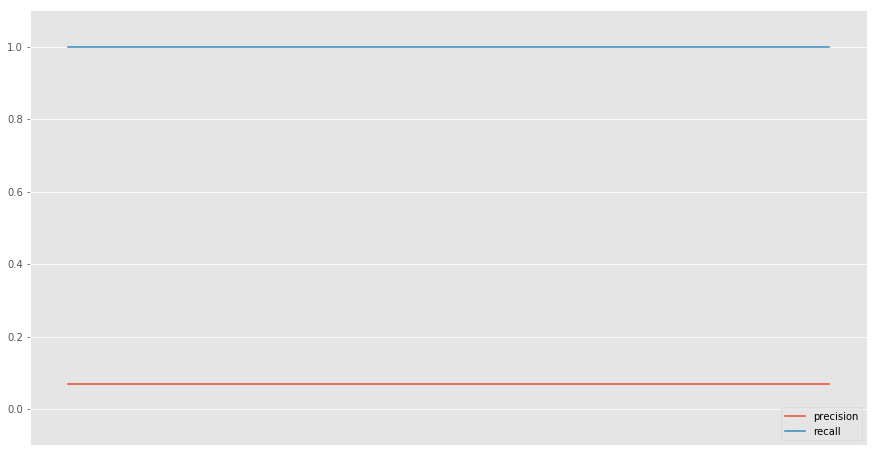

In [19]:
dummy_detector_pipeline(create_constant_detector(0.0), df_scaled, labels_all, k_range)

setting predictions on segments with k =   250, threshold = 0.994
TP:    22 | FP:   142  || sum:  164
FN:    15 | TN:   353  || sum:  368
PRECISION: 0.13, RECALL: 0.59

setting predictions on segments with k =   500, threshold = 0.989
TP:    28 | FP:   232  || sum:  260
FN:     9 | TN:   263  || sum:  272
PRECISION: 0.11, RECALL: 0.76

setting predictions on segments with k =   750, threshold = 0.983
TP:    33 | FP:   290  || sum:  323
FN:     4 | TN:   205  || sum:  209
PRECISION: 0.10, RECALL: 0.89

setting predictions on segments with k =  1000, threshold = 0.978
TP:    35 | FP:   332  || sum:  367
FN:     2 | TN:   163  || sum:  165
PRECISION: 0.10, RECALL: 0.95

setting predictions on segments with k =  1250, threshold = 0.973
TP:    36 | FP:   359  || sum:  395
FN:     1 | TN:   136  || sum:  137
PRECISION: 0.09, RECALL: 0.97

setting predictions on segments with k =  1500, threshold = 0.967
TP:    36 | FP:   380  || sum:  416
FN:     1 | TN:   115  || sum:  116
PRECISION: 0.09, 

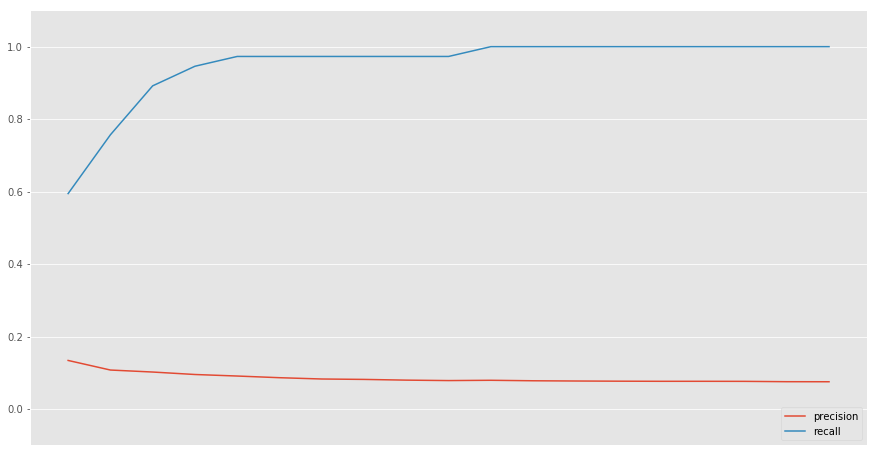

In [20]:
dummy_detector_pipeline(create_uniformly_random_detector(), df_scaled, labels_all, k_range)

setting predictions on segments with k =   250, threshold = 0.833
TP:    25 | FP:   152  || sum:  177
FN:    12 | TN:   343  || sum:  355
PRECISION: 0.14, RECALL: 0.68

setting predictions on segments with k =   500, threshold = 0.699
TP:    31 | FP:   241  || sum:  272
FN:     6 | TN:   254  || sum:  260
PRECISION: 0.11, RECALL: 0.84

setting predictions on segments with k =   750, threshold = 0.696
TP:    35 | FP:   288  || sum:  323
FN:     2 | TN:   207  || sum:  209
PRECISION: 0.11, RECALL: 0.95

setting predictions on segments with k =  1000, threshold = 0.692
TP:    37 | FP:   334  || sum:  371
FN:     0 | TN:   161  || sum:  161
PRECISION: 0.10, RECALL: 1.00

setting predictions on segments with k =  1250, threshold = 0.688
TP:    37 | FP:   358  || sum:  395
FN:     0 | TN:   137  || sum:  137
PRECISION: 0.09, RECALL: 1.00

setting predictions on segments with k =  1500, threshold = 0.684
TP:    37 | FP:   375  || sum:  412
FN:     0 | TN:   120  || sum:  120
PRECISION: 0.09, 

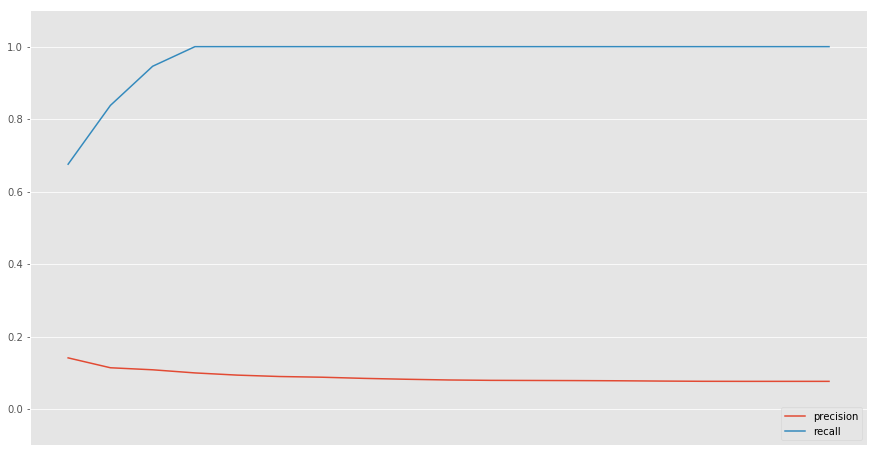

In [21]:
dummy_detector_pipeline(create_stratified_random_detector(0.01), df_scaled, labels_all, k_range)

setting predictions on segments with k =   250, threshold = 0.982
TP:    28 | FP:   139  || sum:  167
FN:     9 | TN:   356  || sum:  365
PRECISION: 0.17, RECALL: 0.76

setting predictions on segments with k =   500, threshold = 0.966
TP:    32 | FP:   228  || sum:  260
FN:     5 | TN:   267  || sum:  272
PRECISION: 0.12, RECALL: 0.86

setting predictions on segments with k =   750, threshold = 0.951
TP:    36 | FP:   291  || sum:  327
FN:     1 | TN:   204  || sum:  205
PRECISION: 0.11, RECALL: 0.97

setting predictions on segments with k =  1000, threshold = 0.935
TP:    36 | FP:   338  || sum:  374
FN:     1 | TN:   157  || sum:  158
PRECISION: 0.10, RECALL: 0.97

setting predictions on segments with k =  1250, threshold = 0.919
TP:    36 | FP:   362  || sum:  398
FN:     1 | TN:   133  || sum:  134
PRECISION: 0.09, RECALL: 0.97

setting predictions on segments with k =  1500, threshold = 0.901
TP:    36 | FP:   381  || sum:  417
FN:     1 | TN:   114  || sum:  115
PRECISION: 0.09, 

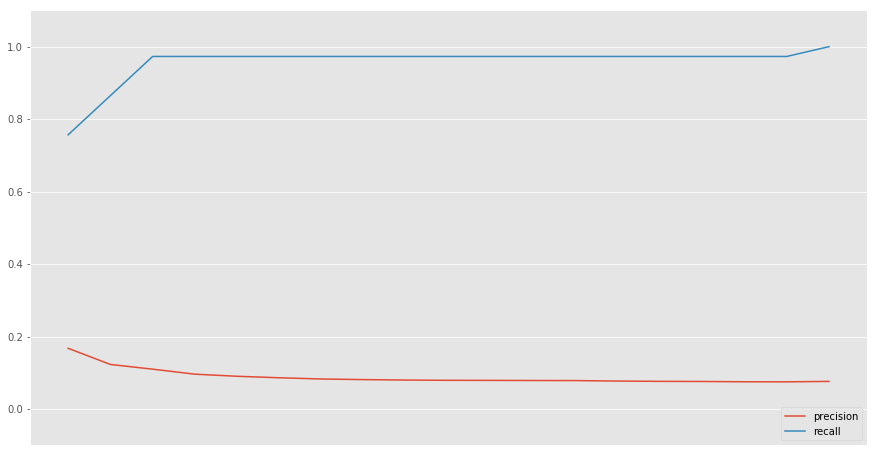

In [22]:
dummy_detector_pipeline(create_stratified_random_detector(0.1), df_scaled, labels_all, k_range)